# Feature engineering on extracted Pull Requests data


## What we did previously

In the previous [notebook](./01_data_collection.ipynb) we collected data from a Github repository of choice and store them on S3 storage

## In this step

In this notebook we will walk through how to start analyzing the PR data collected from a Github repository.

We explore the various fields in the PR dataset and the features that we can derive from them in order to frame an a Machine Learning where we predict the time taken to merge a PR.

In [1]:
import os
import re
import gzip
import json
import boto3
import pathlib
import datetime
from tqdm import tqdm
from io import BytesIO
from pathlib import Path
from functools import partial
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, f_classif

from dotenv import load_dotenv, find_dotenv

In [2]:
class CephCommunication:
    """
    Class to establish communication with a ceph s3 bucket.
    It connects with the bucket and provides methods to read and write data in the parquet format.
    """

    def __init__(
        self, s3_endpoint_url, aws_access_key_id, aws_secret_access_key, s3_bucket
    ):
        self.s3_endpoint_url = s3_endpoint_url
        self.aws_access_key_id = aws_access_key_id
        self.aws_secret_access_key = aws_secret_access_key
        self.s3_resource = boto3.resource(
            "s3",
            endpoint_url=self.s3_endpoint_url,
            aws_access_key_id=self.aws_access_key_id,
            aws_secret_access_key=self.aws_secret_access_key,
        )
        self.bucket = s3_bucket
        ## Todo: Add try catch

    def upload_to_ceph(self, dataframe, s3_path, filename):
        """
        This helper function takes as input the data frame to be uploaded, and the output filename.
        It then saves the data frame in the defined ceph bucket.
        """
        parquet_buffer = BytesIO()
        dataframe.to_parquet(parquet_buffer)
        s3_obj = self.s3_resource.Object(self.bucket, f"{s3_path}/{filename}")
        status = s3_obj.put(Body=parquet_buffer.getvalue())
        return status

    def read_from_ceph(self, s3_path, filename):
        """
        Helper function to read from ceph and see if the saved data is correct.
        """
        buffer = BytesIO()
        s3_object = self.s3_resource.Object(self.bucket, f"{s3_path}/{filename}")
        s3_object.download_fileobj(buffer)
        df_temp = pd.read_parquet(buffer)
        return df_temp


def save_to_disk(dataframe, path, filename):
    """
    Helper function to save the dataframe
    as a parquet file to disk.
    """
    dataset_base_path = Path(path)
    dataset_base_path.mkdir(parents=True, exist_ok=True)
    dataframe.to_parquet(f"{path}/{filename}")
    return True

In [3]:
sns.set(rc={"figure.figsize": (20, 10)})
load_dotenv(find_dotenv(), override=True)

True

In [4]:
## CEPH Bucket variables
## Create a .env file on your local with the correct configs,

ORG = os.getenv("GITHUB_ORG")
REPO = os.getenv("GITHUB_REPO")

## S3 bucket credentials
s3_endpoint_url = os.getenv("S3_ENDPOINT_URL")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")

REMOTE = os.getenv("REMOTE")

s3_input_data_path = os.getenv("CEPH_BUCKET_PREFIX")
local_input_data_path = "../../../data/raw/GitHub/PullRequest.json.gz"
local_output_data_path = "../../../data/processed/github"
RAW_DATA_PATH = os.path.join(
    s3_input_data_path, "srcopsmetrics/bot_knowledge", ORG, REPO, "PullRequest.json"
)

In [5]:
output = []
if REMOTE:
    print("getting dataset from ceph")
    s3 = boto3.resource(
        "s3",
        endpoint_url=s3_endpoint_url,
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
    )
    content = s3.Object(s3_bucket, RAW_DATA_PATH)
    file = content.get()["Body"].read().decode("utf-8")

    prs = json.loads(file)

    for pr in prs.splitlines():
        output.append(json.loads(pr))

else:
    print("getting dataset from local")
    with gzip.open(local_input_data_path, "r") as f:
        prs = json.loads(f.read().decode("utf-8"))

pr_df = pd.DataFrame(output)

getting dataset from ceph


In [6]:
pr_df

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,id
0,update logo and favico,closes #209,XS,zafar-hussain,1666376304,NaN,zafar-hussain,NaN,None,1,2,"{'sesheta': 203, 'zafar-hussain': 19}","{'1151380921': {'author': 'zafar-hussain', 'wo...","[needs-ok-to-test, size/XS]",[a427b9eb7d1a40fa4c6a2419580eee908fe34180],"[img/favicon.png, img/icon.png]",1.666376e+09,NaN,230
1,add knikolla and cleanup,None,S,schwesig,1665410557,1.665411e+09,sesheta,1.665411e+09,sesheta,2,1,"{'schwesig': 175, 'quaid': 1, 'sesheta': 65}",{},"[lgtm, triage/accepted, approved, priority/cri...","[20fcc08d8ebd4e7453469c7fd5492995f156181c, 764...",[OWNERS],NaN,NaN,229
2,pre-commit to clean up existing errors (traili...,None,XS,schwesig,1665402036,1.665409e+09,sesheta,1.665409e+09,sesheta,1,1,"{'schwesig': 9, 'codificat': 16, 'quaid': 3, '...",{},"[lgtm, triage/accepted, approved, priority/cri...",[210de76a23b3cf7f1d0c66b8c82457c597400797],[sig-community/meeting-notes/20221006-meeting-...,NaN,NaN,228
3,Add knikolla,None,XS,schwesig,1665079206,1.665409e+09,schwesig,NaN,None,0,0,"{'quaid': 2, 'schwesig': 7, 'sesheta': 287, 'c...","{'1134003785': {'author': 'schwesig', 'words_c...","[hacktoberfest, hacktoberfest-accepted, size/X...",[],[],1.665127e+09,NaN,225
4,Create 20221006-meeting-notes.md,None,M,schwesig,1665078958,1.665148e+09,schwesig,1.665148e+09,schwesig,1,1,"{'sesheta': 172, 'quaid': 2}","{'1133430644': {'author': 'quaid', 'words_coun...","[kind/documentation, lgtm, approved, size/M, s...",[54c273e75aa9a4a7326c7f9aad1b013bc0c29791],[sig-community/meeting-notes/20221006-meeting-...,1.665079e+09,1.665079e+09,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Created a new document for glossary,This pr adds a glossary document to the repo. ...,L,margarethaley,1625255261,1.625615e+09,sesheta,1.625615e+09,sesheta,2,2,"{'quaid': 4, 'sesheta': 65}","{'699550191': {'author': 'quaid', 'words_count...","[size/L, lgtm, approved]","[28612661c6aa3a338539176e3bef111537e8b79e, f4c...","[glossary.md, new_front_page_mockup.md]",1.625550e+09,NaN,45
91,update the resource limit for the prowjobs,update the resource limit for the prowjobs\r\n...,XS,harshad16,1625177628,1.625230e+09,sesheta,1.625230e+09,sesheta,1,1,"{'harshad16': 3, 'sesheta': 70}","{'698155981': {'author': 'oindrillac', 'words_...","[lgtm, approved, size/XS]",[d89f48d4fd7c01b61847762dfda0b2253cb0e7ed],[.prow.yaml],1.625230e+09,1.625230e+09,44
92,Front page content draft,This pr adds a file containing draft content f...,M,margarethaley,1625167660,1.625254e+09,sesheta,1.625254e+09,sesheta,1,1,"{'margarethaley': 24, 'oindrillac': 104, 'hars...","{'697796698': {'author': 'quaid', 'words_count...","[lgtm, approved, size/M]",[28612661c6aa3a338539176e3bef111537e8b79e],[new_front_page_mockup.md],1.625197e+09,NaN,43
93,Created from existing messages for hacking-on,This is created using the messages on operate-...,M,quaid,1621226623,1.625255e+09,sesheta,1.625255e+09,sesheta,1,1,"{'HumairAK': 60, 'quaid': 96, 'sesheta': 131, ...","{'661390364': {'author': 'HumairAK', 'words_co...","[lgtm, approved]",[03b73f88526078fdce85a6862248f2c8641e60d2],[core_project_message.md],1.621283e+09,NaN,5


In [7]:
pr_df.shape

(95, 19)

In [8]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at,id
0,update logo and favico,closes #209,XS,zafar-hussain,1666376304,NaN,zafar-hussain,NaN,None,1,2,"{'sesheta': 203, 'zafar-hussain': 19}","{'1151380921': {'author': 'zafar-hussain', 'wo...","[needs-ok-to-test, size/XS]",[a427b9eb7d1a40fa4c6a2419580eee908fe34180],"[img/favicon.png, img/icon.png]",1.666376e+09,NaN,230
1,add knikolla and cleanup,None,S,schwesig,1665410557,1.665411e+09,sesheta,1.665411e+09,sesheta,2,1,"{'schwesig': 175, 'quaid': 1, 'sesheta': 65}",{},"[lgtm, triage/accepted, approved, priority/cri...","[20fcc08d8ebd4e7453469c7fd5492995f156181c, 764...",[OWNERS],NaN,NaN,229


## Feature engineering

In the next section we will do some basic feature engineering and correlation analyis on our dataset to see if anything interesting jumps out at us. 

**Time to Merge**

We will derive a new feature called `time_to_merge` which will be the difference between the `created_at` and `merged_at` fields. 

In [9]:
# derive time_to_merege
pr_df["time_to_merge"] = pr_df["merged_at"] - pr_df["created_at"]
pr_df["time_to_merge"] = pr_df["time_to_merge"].astype("float")
# NOTE: we cant fill NA with 0 because that would imply the PR got merged instantaneously

In [10]:
pr_df["time_to_merge"]

0           NaN
1         476.0
2        7081.0
3           NaN
4       68588.0
        ...    
90     359974.0
91      52870.0
92      86385.0
93    4028019.0
94      16676.0
Name: time_to_merge, Length: 95, dtype: float64

Let's look at the distribution of the time to merge column. This can help us determine what the setup for ML problems such as [#236](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/236) could be like. That is, should the time to merge problem be framed as a regression or classification problem.

First, lets try to determine what the granularity of the output values should be, in case of a regression setup. That is, should the model predict time to merge in number of seconds, number of hours, number of days, or some other chunk of time.

In [11]:
# what does the distribution of values look like if we choose days as the granularity
ttm_days = np.ceil(pr_df.time_to_merge / (60 * 60 * 24))

# value counts - to how many PRs have value 1, 2, 3, etc. for days to merge
vc = ttm_days.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0     0.6000
4.0     0.0500
12.0    0.0250
5.0     0.0250
24.0    0.0250
7.0     0.0250
14.0    0.0250
28.0    0.0250
10.0    0.0125
6.0     0.0125
35.0    0.0125
27.0    0.0125
21.0    0.0125
9.0     0.0125
8.0     0.0125
15.0    0.0125
2.0     0.0125
42.0    0.0125
26.0    0.0125
18.0    0.0125
13.0    0.0125
44.0    0.0125
3.0     0.0125
47.0    0.0125
Name: time_to_merge, dtype: float64

In [12]:
# what if we chose some intermediate value e.g. 3 hours as the granularity?
ttm_3hours = np.ceil(pr_df.time_to_merge / (60 * 60 * 3))

# value counts - to how many PRs have value 1, 2, 3, etc. for num. 3-hours to merge
vc = ttm_3hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0      0.3375
6.0      0.0625
7.0      0.0500
8.0      0.0375
2.0      0.0375
5.0      0.0375
96.0     0.0250
25.0     0.0250
4.0      0.0250
217.0    0.0250
3.0      0.0125
74.0     0.0125
65.0     0.0125
164.0    0.0125
212.0    0.0125
118.0    0.0125
30.0     0.0125
280.0    0.0125
46.0     0.0125
37.0     0.0125
34.0     0.0125
55.0     0.0125
205.0    0.0125
112.0    0.0125
9.0      0.0125
58.0     0.0125
144.0    0.0125
106.0    0.0125
102.0    0.0125
32.0     0.0125
50.0     0.0125
189.0    0.0125
185.0    0.0125
346.0    0.0125
22.0     0.0125
335.0    0.0125
373.0    0.0125
Name: time_to_merge, dtype: float64

In [13]:
# what if we chose hours as the granularity?
ttm_hours = np.ceil(pr_df.time_to_merge / (60 * 60))

# value counts - to how many PRs have value 1, 2, 3, etc. for hours to merge
vc = ttm_hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0       0.3000
16.0      0.0375
5.0       0.0250
17.0      0.0250
2.0       0.0250
73.0      0.0250
15.0      0.0250
20.0      0.0250
21.0      0.0125
19.0      0.0125
24.0      0.0125
165.0     0.0125
100.0     0.0125
220.0     0.0125
193.0     0.0125
490.0     0.0125
8.0       0.0125
651.0     0.0125
635.0     0.0125
88.0      0.0125
12.0      0.0125
335.0     0.0125
649.0     0.0125
838.0     0.0125
137.0     0.0125
111.0     0.0125
354.0     0.0125
173.0     0.0125
26.0      0.0125
148.0     0.0125
23.0      0.0125
1003.0    0.0125
288.0     0.0125
66.0      0.0125
1038.0    0.0125
555.0     0.0125
4.0       0.0125
565.0     0.0125
96.0      0.0125
3.0       0.0125
304.0     0.0125
287.0     0.0125
317.0     0.0125
432.0     0.0125
11.0      0.0125
615.0     0.0125
13.0      0.0125
22.0      0.0125
1119.0    0.0125
Name: time_to_merge, dtype: float64

Now, lets try to determine, if we were to set this up as a classification problem, what the output classes should be. In the following cell, we'll try to split the time-to-merge values into 10 equally populated buckets.

In [14]:
# lets look at what the 10th, 20th, 30th etc percentiles are, to see what the bin boundaries (in terms of hours)
# would be if we were to split the data in 10 equally populated bins
n_buckets = 10

quantiles = pr_df.time_to_merge.quantile(q=np.arange(0, 1 + 1e-100, 1 / n_buckets))
quantiles / 3600

0.0      0.003056
0.1      0.013361
0.2      0.090833
0.3      1.234028
0.4     11.030444
0.5     16.645833
0.6     24.554278
0.7    118.527222
0.8    290.272000
0.9    569.101083
Name: time_to_merge, dtype: float64

In [15]:
intervals = quantiles

In [16]:
# gaps between the buckets (i.e. size of each bucket) in hours
(quantiles - quantiles.shift()) / 3600

0.0           NaN
0.1      0.010306
0.2      0.077472
0.3      1.143194
0.4      9.796417
0.5      5.615389
0.6      7.908444
0.7     93.972944
0.8    171.744778
0.9    278.829083
Name: time_to_merge, dtype: float64

If we want to frame our ML problem as a classification problem, we can use the above buckets to define the classes.

**Body**

Here, we will derive a feature called `body_size` which will simply be the number of words in the body of the PR. We can use this numerical value to describe the body of the PR.

In [17]:
# derive body_size
pr_df["body_size"] = pr_df["body"].fillna("").apply(lambda x: len(x.split()))

In [18]:
pr_df["body_size"]

0      2
1      0
2      0
3      0
4      0
      ..
90    48
91    16
92    38
93    34
94     3
Name: body_size, Length: 95, dtype: int64

**Size**

We can attempt to convert the categorical size label generated by GitHub, which summarizes the size of the changes made to the code base, to a numerical value. 

In [19]:
set(pr_df['size'])

{'L', 'M', 'S', 'XL', 'XS', 'XXL'}

In [20]:
convert_size = {"size": {"NaN": 0, "XS": 0, "S": 1, "M": 2, "L": 3, "XL": 4, "XXL": 5}}
pr_df = pr_df.replace(convert_size)

**Title**

Lets try to see if the PR title text can be used to extract any useful information regarding the PR.

In [21]:
# first lets preprocess the text available in the titles

# convert to lowercase
preproc_titles = pr_df["title"].str.lower()

# remove punctuations and symbols like : ; , # ( ) [ ] etc
preproc_titles = preproc_titles.str.replace(r'[`#-.?!,:;\/()\[\]"\']', " ", regex=True)

# remove hash-like strings i.e. 25+ char long strings containing 0-9 or a-f
preproc_titles = preproc_titles.str.replace(r"[0-9a-f]{25,}", " ", regex=True)

preproc_titles

0                                update logo and favico
1                              add knikolla and cleanup
2     pre commit to clean up existing errors  traili...
3                                          add knikolla
4                      create 20221006 meeting notes md
                            ...                        
90                  created a new document for glossary
91           update the resource limit for the prowjobs
92                             front page content draft
93        created from existing messages for hacking on
94                           chore  add quaid to owners
Name: title, Length: 95, dtype: object

In [22]:
# what are the most commonly appearing words in the titles

# combin all titles and split into words
words = preproc_titles.str.cat(sep=" ").split()

# remove stopwords and numbers (e.g. bugzilla ids)
words = [w for w in words if w not in set(STOPWORDS) and not w.isnumeric()]

# word frequencies
unique_words, counts = np.unique(words, return_counts=True)
vc = pd.Series(counts, index=unique_words).sort_values(ascending=False)

From the above graph, we can see that titles often contain some keywords that can hint towards the type of changes being made in the PR. We will create a feature which is a vector indicating how many times each word appeared in the title. This way, even if a less prominent word is more correlated with time_to_merge, we will be able to capture that relationship.

In [23]:
# add word count columns
for word in tqdm(unique_words):
    pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
        lambda x: x.split().count(word)
    )

  0%|          | 0/228 [00:00<?, ?it/s]/tmp/ipykernel_236/4191214648.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
 43%|████▎     | 97/228 [00:00<00:00, 348.12it/s]/tmp/ipykernel_236/4191214648.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
/tmp/ipykernel_236/4191214648.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

In [24]:
# collapse the high dim vector into one column
wordcount_columns = [c for c in pr_df.columns if "wordcount" in c]
pr_df["title_word_counts_vec"] = pr_df[wordcount_columns].apply(
    lambda x: x.tolist(), axis=1
)

# drop the individual wordcount columns
pr_df = pr_df.drop(columns=wordcount_columns)

**Created At**

This column can give us information on when the PR was created. Using the `created_at` field, we can derive other features like `time_of_day`, `day_of_week`, `day_of_month`, `month_in_year` each of which can be categorical features that can be useful to our analysis.

In [25]:
# convert to datetime object
pr_df["created_at_datetime"] = (
    pr_df["created_at"].fillna("").apply(lambda x: datetime.datetime.fromtimestamp(x))
)
# get day as categorical variable
pr_df["created_at_day"] = pr_df["created_at_datetime"].apply(lambda x: x.day)

# get month as categorical variable
pr_df["created_at_month"] = pr_df["created_at_datetime"].apply(lambda x: x.month)

# get weekday as categorical variable
pr_df["created_at_weekday"] = pr_df["created_at_datetime"].apply(lambda x: x.weekday())

# get hour of day as categorical variable
pr_df["created_at_hour"] = pr_df["created_at_datetime"].apply(lambda x: x.hour)

In [26]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,first_approve_at,id,time_to_merge,body_size,title_word_counts_vec,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
0,update logo and favico,closes #209,0,zafar-hussain,1666376304,NaN,zafar-hussain,NaN,None,1,...,NaN,230,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-10-21 18:18:24,21,10,4,18
1,add knikolla and cleanup,None,1,schwesig,1665410557,1.665411e+09,sesheta,1.665411e+09,sesheta,2,...,NaN,229,476.0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-10-10 14:02:37,10,10,0,14


**Changed Files Number**  
Changed files is a numberical variable which captures the numer of files that were modified in the PR.

In [27]:
# convert changed_files_number to int
pr_df["changed_files_number"] = pr_df["changed_files_number"].astype("int")

pr_df.changed_files_number.value_counts()

1     55
2     18
3      5
0      4
5      3
6      3
8      2
7      2
4      1
12     1
17     1
Name: changed_files_number, dtype: int64

`changed_files_number` has more variability than the `commits_number`. We can incorporate this as a numerical feature.

**Changed_files**

`changed_files` is a list of the paths and filenames for every file changed by this PR. From `changed_files`, we know, for each PR, which file types were changed which can be encoded as a frequency vector. Also we know which directory the change is made in, so that can be encoded as a categorical variable.

In [28]:
pr_df.changed_files

0                       [img/favicon.png, img/icon.png]
1                                              [OWNERS]
2     [sig-community/meeting-notes/20221006-meeting-...
3                                                    []
4     [sig-community/meeting-notes/20221006-meeting-...
                            ...                        
90              [glossary.md, new_front_page_mockup.md]
91                                         [.prow.yaml]
92                           [new_front_page_mockup.md]
93                            [core_project_message.md]
94                                             [OWNERS]
Name: changed_files, Length: 95, dtype: object

In [29]:
def filetype(filepath):

    # if standard file extension, return file extension
    if pathlib.Path(filepath).suffix:
        return pathlib.Path(filepath).suffix

    else:
        # if single file at the root of repo
        if "/" not in filepath:
            # if a file like README/Dockerfile etc
            if "." not in filepath:
                return filepath
        # if file not at root
        else:
            # get file name
            file = filepath.rsplit("/", 1)[1]
            if "." not in file:
                return file
            elif "." in file:
                return "." + file.rsplit(".", 1)[1]

In [30]:
# get list of all file types that were modified across all openshift origin PRs
changed_files = list(pr_df["changed_files"])

In [31]:
all_changed_files = [filetype(filepath) for pr in changed_files for filepath in pr]

In [32]:
count = Counter(all_changed_files)

In [33]:
# save 100 most commonly occuring file extensions across PRs
top_fileextensions_freq = count.most_common(100)
top_fileextensions = [ext[0] for ext in top_fileextensions_freq]

In [34]:
top_fileextensions

['.md',
 '.yaml',
 '.tmpl',
 'OWNERS',
 'OWNERS_ALIASES',
 '.yml',
 '.png',
 '.ipynb',
 '.txt',
 '.json']

In [35]:
def file_type_freq(list_of_filepaths):
    """
    For a given PR's list of changed files,
    return a changed files frequency vector
    ( a vector which holds the frequency of
    changed files of the type  for every
    file type in top_fileextensions )
    """

    file_extensions = [filetype(f) for f in list_of_filepaths]
    ext_dict = {key: 0 for key in top_fileextensions}
    for f in file_extensions:
        if f in ext_dict:
            ext_dict[f] += 1

    return list(ext_dict.values())

In [36]:
pr_df["changed_file_type_vec"] = pr_df["changed_files"].apply(
    lambda x: file_type_freq(x)
)

In [37]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,id,time_to_merge,body_size,title_word_counts_vec,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_file_type_vec
0,update logo and favico,closes #209,0,zafar-hussain,1666376304,NaN,zafar-hussain,NaN,None,1,...,230,NaN,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-10-21 18:18:24,21,10,4,18,"[0, 0, 0, 0, 0, 0, 2, 0, 0, 0]"
1,add knikolla and cleanup,None,1,schwesig,1665410557,1.665411e+09,sesheta,1.665411e+09,sesheta,2,...,229,476.0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2022-10-10 14:02:37,10,10,0,14,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


## Create PR trends dashboard

## Infer dataframe columns as Features

We can see above that some PRs have 0 for all directory fields since the directory structure of the repo has changed over time and we are interested in only the latest directory structure.

In [38]:
# subset DataFrame to use as features
feature_df = pr_df[
    [
        "time_to_merge",
        "changed_files_number",
        "body_size",
        "size",
        "title_word_counts_vec",
        "created_at_day",
        "created_at_month",
        "created_at_weekday",
        "created_at_hour",
        "commits_number",
        "changed_file_type_vec",
    ]
]

### Add PR TTM Class Column 

Lets split up the time to merge values into 10 discrete bins (as discussed above) to use as our prediction classes.

In [39]:
intervals

0.0         11.0
0.1         48.1
0.2        327.0
0.3       4442.5
0.4      39709.6
0.5      59925.0
0.6      88395.4
0.7     426698.0
0.8    1044979.2
0.9    2048763.9
Name: time_to_merge, dtype: float64

In [40]:
def get_ttm_class(ttm):

    for rownum, (indx, val) in enumerate(intervals.iteritems()):
        if ttm < val:
            return rownum - 1
    return 9


feature_df["ttm_class"] = (feature_df["time_to_merge"]).apply(get_ttm_class)
feature_df.head()

/tmp/ipykernel_236/2436122750.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["ttm_class"] = (feature_df["time_to_merge"]).apply(get_ttm_class)


,time_to_merge,changed_files_number,body_size,size,title_word_counts_vec,created_at_day,created_at_month,created_at_weekday,created_at_hour,commits_number,changed_file_type_vec,ttm_class
0,NaN,2,2,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",21,10,4,18,1,"[0, 0, 0, 0, 0, 0, 2, 0, 0, 0]",9
1,476.0,1,0,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,10,0,14,2,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",2
2,7081.0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,10,0,11,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",3
3,NaN,0,0,0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,10,3,18,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",9
4,68588.0,1,0,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,10,3,17,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5


## Evaluating Feature Importances

### Categorical Features

First, lets try to determine what categorical featuers are powerful influencers for time to merge of a PR

In [41]:
# feature selection helper function
def select_features(x, y, func):
    fs = SelectKBest(score_func=func, k="all")
    fs.fit(x, y)
    x_fs = fs.transform(x)
    return x_fs, fs


selected_features = []

In [42]:
cat_features = [
    "size",
    "created_at_day",
    "created_at_month",
    "created_at_weekday",
    "created_at_hour",
    "ttm_class",
]

In [43]:
cat_df = feature_df[cat_features]

cat_df.head()

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,ttm_class
0,0,21,10,4,18,9
1,1,10,10,0,14,2
2,0,10,10,0,11,3
3,0,6,10,3,18,9
4,2,6,10,3,17,5


In [44]:
# split into input (x) and output (y) variables
X_inp = cat_df.drop(columns=["ttm_class"])
y = cat_df["ttm_class"]

In [45]:
# rank using mutual_info_classif
X_fs, fs = select_features(X_inp, y, mutual_info_classif)

In [46]:
for i in range(len(fs.scores_)):
    print("Feature %s: %f" % (X_inp.columns[i], fs.scores_[i]))

Feature size: 0.115507
Feature created_at_day: 0.354328
Feature created_at_month: 0.040582
Feature created_at_weekday: 0.097960
Feature created_at_hour: 0.124732


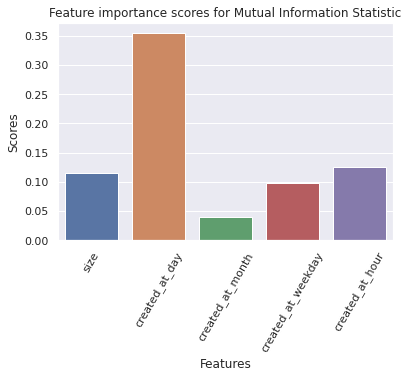

In [47]:
# visualize scores of all features
sns.barplot(x=X_inp.columns, y=fs.scores_)
plt.title("Feature importance scores for Mutual Information Statistic")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

In [48]:
# Lets get a list of the top 10 feature indices based on Mutual Info Stat feature scores
top_mis = fs.scores_.argsort()[-10:][::-1]

In [49]:
# rank using chi_sq
X_fs, fs = select_features(X_inp, y, chi2)

In [50]:
for i in range(len(fs.scores_)):
    print("Feature %s: %f" % (X_inp.columns[i], fs.scores_[i]))

Feature size: 8.088888
Feature created_at_day: 99.353417
Feature created_at_month: 23.376169
Feature created_at_weekday: 10.480045
Feature created_at_hour: 20.373082


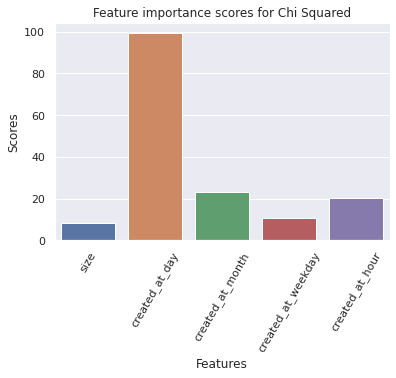

In [51]:
# visualize scores of all features
sns.barplot(x=X_inp.columns, y=fs.scores_)
plt.title("Feature importance scores for Chi Squared")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

In [52]:
# Lets get a list of the top 10 feature indices based on Chi Sq feature scores
top_chi2 = fs.scores_.argsort()[-10:][::-1]

Let's get a Union of the top 10 features derived from features based on both scores of both Mutual Info Statistic and Chi Squared

In [53]:
union = set(top_mis).union(set(top_chi2))
print(len(union))
union

5


{0, 1, 2, 3, 4}

In [54]:
selected_cat_features = [cat_features[i] for i in union]
selected_cat_features

['size',
 'created_at_day',
 'created_at_month',
 'created_at_weekday',
 'created_at_hour']

In [55]:
# update list of features to keep for training
selected_features += selected_cat_features

### Numerical Features

Now, lets try to determine what numerical featuers are powerful influencers for time to merge of a PR

In [56]:
numerical_features = [
    "changed_files_number",
    "body_size",
    "commits_number",
    "ttm_class",
]

In [57]:
numerical_df = feature_df[numerical_features]
numerical_df.head()

,changed_files_number,body_size,commits_number,ttm_class
0,2,2,1,9
1,1,0,2,2
2,1,0,1,3
3,0,0,0,9
4,1,0,1,5


In [58]:
# split into input features and target
X_inp = numerical_df.drop(columns=["ttm_class"])
y = numerical_df["ttm_class"]

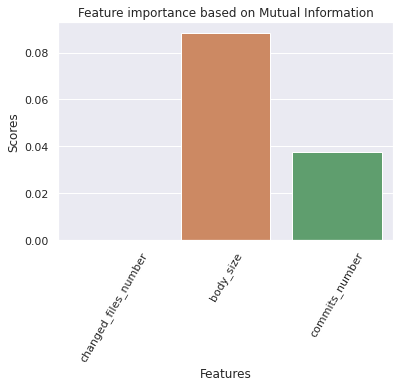

In [59]:
# create k best feature selector object based on mutual information
numerical_feats_mi, k_best_selector_mi = select_features(
    X_inp,
    y,
    partial(
        mutual_info_classif,
        discrete_features=False,
        random_state=42,
        n_neighbors=3,
    ),
)

# visualize the MI scores of all features
sns.barplot(x=X_inp.columns, y=k_best_selector_mi.scores_)
plt.title("Feature importance based on Mutual Information")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

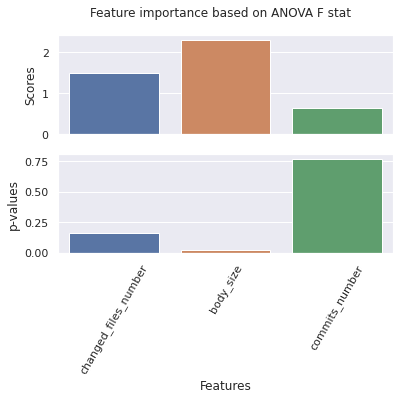

In [60]:
# create k best feature selector object based on anova f statistic
numerical_feats_f, k_best_selector_f = select_features(
    X_inp,
    y,
    f_classif,
)

# visualize the f stat scores and pvalues of all features
fig, axes = plt.subplots(2, 1, sharex=True)
fig.suptitle("Feature importance based on ANOVA F stat")
sns.barplot(x=X_inp.columns, y=k_best_selector_f.scores_, ax=axes[0])
sns.barplot(x=X_inp.columns, y=k_best_selector_f.pvalues_, ax=axes[1])
plt.xticks(rotation=60)
plt.xlabel("Features")
axes[0].set_ylabel("Scores")
axes[1].set_ylabel("p-values")
plt.show()

In [61]:
top_mi = k_best_selector_mi.scores_.argsort()[-3:][::-1]
top_anova = k_best_selector_f.scores_.argsort()[-3:][::-1]
union = set(top_mi).union(set(top_anova))
union

{0, 1, 2}

In [62]:
selected_num_features = [numerical_features[i] for i in union]
selected_num_features

['changed_files_number', 'body_size', 'commits_number']

In [63]:
# update list of features to keep for training
selected_features += selected_num_features

### Count Vector Type Features

Finally, lets determine the most important features from the count vector type columns.

In [64]:
# explode the list column so that there is 1 column representing frequency of each file type
filetype_df = pd.DataFrame(feature_df.changed_file_type_vec.to_list())
filetype_df.index = feature_df.index
filetype_df.columns = [f"filetype_{f}" for f in top_fileextensions]

In [65]:
# compute correlation with ttm
corr = filetype_df.corrwith(feature_df["ttm_class"])
corr.sort_values(ascending=False)

filetype_OWNERS            0.086928
filetype_.yaml             0.083330
filetype_.tmpl             0.055068
filetype_.png              0.032950
filetype_.json             0.026226
filetype_OWNERS_ALIASES   -0.021935
filetype_.txt             -0.040214
filetype_.ipynb           -0.061531
filetype_.md              -0.071170
filetype_.yml             -0.115608
dtype: float64

In [66]:
corr[corr.abs() > 0.01]

filetype_.md              -0.071170
filetype_.yaml             0.083330
filetype_.tmpl             0.055068
filetype_OWNERS            0.086928
filetype_OWNERS_ALIASES   -0.021935
filetype_.yml             -0.115608
filetype_.png              0.032950
filetype_.ipynb           -0.061531
filetype_.txt             -0.040214
filetype_.json             0.026226
dtype: float64

In [67]:
# update list of features to keep for training
# take everything that has more than 0.01 correlation magnitude
filetype_keep_cols = corr[corr.abs() > 0.01].index.tolist()
selected_features += filetype_keep_cols

# only keep the relevant columns now
filetype_df = filetype_df[filetype_keep_cols]

In [68]:
filetype_keep_cols = [i[9:] for i in filetype_keep_cols]
filetype_keep_cols

['.md',
 '.yaml',
 '.tmpl',
 'OWNERS',
 'OWNERS_ALIASES',
 '.yml',
 '.png',
 '.ipynb',
 '.txt',
 '.json']

In [69]:
filetype_keep_cols_df = pd.DataFrame(filetype_keep_cols, columns=["filetype"])

In [70]:
filetype_keep_cols_df

,filetype
0,.md
1,.yaml
2,.tmpl
3,OWNERS
4,OWNERS_ALIASES
5,.yml
6,.png
7,.ipynb
8,.txt
9,.json


In [71]:
FILETYPE_FEATURES_FILENAME = os.path.join(ORG + REPO + "FILETYPE.parquet")
FILETYPE_FEATURES_KEY = os.path.join(s3_input_data_path, ORG, REPO, "features")
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
cc.upload_to_ceph(
    filetype_keep_cols_df, FILETYPE_FEATURES_KEY, FILETYPE_FEATURES_FILENAME
)

{'ResponseMetadata': {'RequestId': 'la19qe1q-d99v5i-1bq2',
  'HostId': 'la19qe1q-d99v5i-1bq2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-request-id': 'la19qe1q-d99v5i-1bq2',
   'x-amz-id-2': 'la19qe1q-d99v5i-1bq2',
   'access-control-allow-origin': '*',
   'access-control-allow-credentials': 'true',
   'access-control-allow-methods': 'GET,POST,PUT,DELETE,OPTIONS',
   'access-control-allow-headers': 'Content-Type,Content-MD5,Authorization,X-Amz-User-Agent,X-Amz-Date,ETag,X-Amz-Content-Sha256',
   'access-control-expose-headers': 'ETag,X-Amz-Version-Id',
   'etag': '"d9f842798cdbf415f36d3341c52a46ff"',
   'date': 'Thu, 03 Nov 2022 16:14:43 GMT',
   'keep-alive': 'timeout=5',
   'content-length': '0',
   'set-cookie': '1a4aa612fe797ac8466d7ee00e5520d5=a26d7dd2bae782e2ad6181b7887b5ff1; path=/; HttpOnly; Secure; SameSite=None'},
  'RetryAttempts': 0},
 'ETag': '"d9f842798cdbf415f36d3341c52a46ff"'}

In [72]:
# explode the list column so that there is 1 column representing frequency of each word
title_wordcount_df = pd.DataFrame(feature_df.title_word_counts_vec.to_list())

title_wordcount_df.index = feature_df.index
title_wordcount_df.columns = [f"title_wordcount_{w}" for w in unique_words]

In [73]:
# compute correlation with ttm
corr = title_wordcount_df.corrwith(feature_df["ttm_class"])
corr = corr.dropna()
corr.sort_values(ascending=False)

title_wordcount_charter      0.226946
title_wordcount_minor        0.220399
title_wordcount_details      0.220399
title_wordcount_docs         0.214462
title_wordcount_services     0.201012
                               ...   
title_wordcount_create      -0.228105
title_wordcount_office      -0.246104
title_wordcount_hours       -0.246104
title_wordcount_gitaction   -0.246104
title_wordcount_path        -0.246104
Length: 228, dtype: float64

In [74]:
corr[corr.abs() > 0.04]

title_wordcount_19_meeting       -0.139874
title_wordcount_26_meeting       -0.139874
title_wordcount_@margarethaley   -0.040214
title_wordcount_action           -0.104408
title_wordcount_actions          -0.139874
                                    ...   
title_wordcount_weekly           -0.106654
title_wordcount_whitespace       -0.073434
title_wordcount_word              0.092666
title_wordcount_wording          -0.173094
title_wordcount_workload          0.059446
Length: 180, dtype: float64

In [75]:
# update list of features to keep for training
# take everything that has more than 0.01 correlation magnitude
title_word_keep_cols = corr[corr.abs() > 0.04].index.tolist()
selected_features += title_word_keep_cols

title_wordcount_df = title_wordcount_df[title_word_keep_cols]

In [76]:
title_word_keep_cols = [i[16:] for i in title_word_keep_cols]
title_word_keep_cols

['19_meeting',
 '26_meeting',
 '@margarethaley',
 'action',
 'actions',
 'add',
 'added',
 'adding',
 'addition',
 'airgapped',
 'analysis',
 'approach',
 'around',
 'bad',
 'bi',
 'build',
 'calendar',
 'carlosgimeno',
 'catalog',
 'change',
 'changes',
 'charter',
 'checklist',
 'chore',
 'clarity',
 'cleanup',
 'cluster',
 'commit',
 'complete',
 'completion',
 'context',
 'contrib_x',
 'contributors',
 'corrections',
 'create',
 'created',
 'creation',
 'curator',
 'definition',
 'dependencies',
 'details',
 'dir',
 'directory',
 'discussion',
 'docs',
 'document',
 'ds',
 'dynamics',
 'errors',
 'evolving',
 'faq',
 'favico',
 'feat',
 'file',
 'files',
 'first',
 'fix',
 'fixed',
 'fixes',
 'fixing',
 'follow',
 'forgotten',
 'forming',
 'fybrik',
 'gap',
 'generator',
 'git',
 'gitaction',
 'github',
 'give',
 'governance',
 'group',
 'groups',
 'guide',
 'hacking',
 'highlighting',
 'hours',
 'inclusive',
 'interactions',
 'internal_contributors',
 'jbook',
 'july',
 'jupyterbo

In [77]:
title_word_keep_cols_df = pd.DataFrame(title_word_keep_cols, columns=["title"])

In [78]:
title_word_keep_cols_df

,title
0,19_meeting
1,26_meeting
2,@margarethaley
3,action
4,actions
...,...
175,weekly
176,whitespace
177,word
178,wording


In [79]:
TITLE_FEATURES_FILENAME = os.path.join(ORG + REPO + "titlewords.parquet")
TITLE_FEATURES_KEY = os.path.join(s3_input_data_path, ORG, REPO, "features")
cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
cc.upload_to_ceph(title_word_keep_cols_df, TITLE_FEATURES_KEY, TITLE_FEATURES_FILENAME)

{'ResponseMetadata': {'RequestId': 'la19qeja-76h8zj-16r4',
  'HostId': 'la19qeja-76h8zj-16r4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-request-id': 'la19qeja-76h8zj-16r4',
   'x-amz-id-2': 'la19qeja-76h8zj-16r4',
   'access-control-allow-origin': '*',
   'access-control-allow-credentials': 'true',
   'access-control-allow-methods': 'GET,POST,PUT,DELETE,OPTIONS',
   'access-control-allow-headers': 'Content-Type,Content-MD5,Authorization,X-Amz-User-Agent,X-Amz-Date,ETag,X-Amz-Content-Sha256',
   'access-control-expose-headers': 'ETag,X-Amz-Version-Id',
   'etag': '"d91a1be29bd123bfe44bb328b9092daf"',
   'date': 'Thu, 03 Nov 2022 16:14:44 GMT',
   'keep-alive': 'timeout=5',
   'content-length': '0',
   'set-cookie': '1a4aa612fe797ac8466d7ee00e5520d5=a26d7dd2bae782e2ad6181b7887b5ff1; path=/; HttpOnly; Secure; SameSite=None'},
  'RetryAttempts': 0},
 'ETag': '"d91a1be29bd123bfe44bb328b9092daf"'}

Using various feature importance scores such as chi-squared, mutual information statistic, correlation values, we have selected the most relevant features amongst all of our features. 

In [80]:
selected_features

['size',
 'created_at_day',
 'created_at_month',
 'created_at_weekday',
 'created_at_hour',
 'changed_files_number',
 'body_size',
 'commits_number',
 'filetype_.md',
 'filetype_.yaml',
 'filetype_.tmpl',
 'filetype_OWNERS',
 'filetype_OWNERS_ALIASES',
 'filetype_.yml',
 'filetype_.png',
 'filetype_.ipynb',
 'filetype_.txt',
 'filetype_.json',
 'title_wordcount_19_meeting',
 'title_wordcount_26_meeting',
 'title_wordcount_@margarethaley',
 'title_wordcount_action',
 'title_wordcount_actions',
 'title_wordcount_add',
 'title_wordcount_added',
 'title_wordcount_adding',
 'title_wordcount_addition',
 'title_wordcount_airgapped',
 'title_wordcount_analysis',
 'title_wordcount_approach',
 'title_wordcount_around',
 'title_wordcount_bad',
 'title_wordcount_bi',
 'title_wordcount_build',
 'title_wordcount_calendar',
 'title_wordcount_carlosgimeno',
 'title_wordcount_catalog',
 'title_wordcount_change',
 'title_wordcount_changes',
 'title_wordcount_charter',
 'title_wordcount_checklist',
 'tit

## Save Feature Engineered Dataset

In [81]:
# join all types of features
ttm_dataset = pd.concat(
    [feature_df, filetype_df, title_wordcount_df], axis=1, ignore_index=False
)

# keep only the selected features and the prediction label
ttm_dataset = ttm_dataset[selected_features + ["ttm_class", "time_to_merge"]]

ttm_dataset.head()

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,commits_number,filetype_.md,filetype_.yaml,...,title_wordcount_watercooler,title_wordcount_website,title_wordcount_week,title_wordcount_weekly,title_wordcount_whitespace,title_wordcount_word,title_wordcount_wording,title_wordcount_workload,ttm_class,time_to_merge
0,0,21,10,4,18,2,2,1,0,0,...,0,0,0,0,0,0,0,0,9,NaN
1,1,10,10,0,14,1,0,2,0,0,...,0,0,0,0,0,0,0,0,2,476.0
2,0,10,10,0,11,1,0,1,1,0,...,0,0,0,0,1,0,0,0,3,7081.0
3,0,6,10,3,18,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,NaN
4,2,6,10,3,17,1,0,1,1,0,...,0,0,0,0,0,0,0,0,5,68588.0


In [82]:
ttm_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Columns: 200 entries, size to time_to_merge
dtypes: float64(1), int64(199)
memory usage: 148.6 KB


## Save results to Ceph or locally

Using the helper function to save the data frame in a parquet format on the Ceph bucket if we are running in automation, and locally if not.

In [83]:
TTM_DATASET_PATH = os.path.join(s3_input_data_path, ORG, REPO)

In [84]:
## Sanity check to see if the dataset is the same

if REMOTE:
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    try:
        cc.upload_to_ceph(
            ttm_dataset,
            TTM_DATASET_PATH,
            "ttm_feature_engineered_dataset.parquet",
        )
    except ValueError as ve:
        print(ve)
        print("Files already uploaded to S3")

else:
    save_to_disk(
        ttm_dataset,
        local_output_data_path,
        "ttm_dataset.parquet",
    )

### Check contents of the S3 bucket so far

In [85]:
# check all raw data files in s3
bucket = cc.s3_resource.Bucket(s3_bucket)
objects = [i for i in bucket.objects.all() if s3_input_data_path + "/" in i.key]
sorted(objects, key=lambda x: x.key)

[s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov3/operate-first/community/features/operate-firstcommunityFILETYPE.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov3/operate-first/community/features/operate-firstcommunitytitlewords.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov3/operate-first/community/ttm_feature_engineered_dataset.parquet'),
 s3.ObjectSummary(bucket_name='opf-datacatalog', key='nov3/srcopsmetrics/bot_knowledge/operate-first/community/PullRequest.json')]

# Conclusion

This notebook walked through how to access saved raw Pull Requests data from the previous data collection notebook and we engineered some possible features which can be used to predict time to merge of a PR. 

The features we engineered are as following:

- time_to_merge: time taken to merge a PR in seconds, this is feature we will try to predict
- changed_files_number: integer indicating the number of files changed, this is an available column
- body_size: integer indicating the number of words in the body of the PR, derived from body
- size: integer corresponding to a categorical label generated by GitHub which summarizes the size of the changes made to the code base 
- title_word_counts_vec: vector or list indicating how many times each word appeared in the title
- created_at_day: categorical variable indicating the day of month the PR has been created, derived from created_at
- created_at_month: categorical variable indicating the month of the year that the PR has been created, derived from created_at
- created_at_weekday: categorical variable indicating the day of the week the PR has been created, derived from created_at
- created_at_hour: categorical variable indicating the hour of the day the PR has been created, derived from created_at
- commits_number: integer indicating the number of commits in the PR
- changed_file_type_vec:  vector or list consisting of number of files changed for the top 100 most frequently occurring data types, derived from changed_files


# Next Step

In the next [notebook](./03_model_training.ipynb), we will train a classifier to predict time to merge of a PR using the features.